<a href="https://colab.research.google.com/github/MoustHolmes/AMAS_Project/blob/main/DDPG_LunarLander.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installs

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# render installs 
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1
# from IPython import display as ipythondisplay

# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(400, 300))
# display.start()

In [ ]:
%%bash
# install required system dependencies
apt-get install -y xvfb x11-utils
# install required python dependencies
pip install gym[box2d]==0.17.* \
            pyvirtualdisplay==0.2.* \
            PyOpenGL==3.1.* \
            PyOpenGL-accelerate==3.1.*

Reading package lists...
Building dependency tree...
Reading state information...
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils xvfb
0 upgraded, 3 newly installed, 0 to remove and 35 not upgraded.
Need to get 993 kB of archives.
After this operation, 2,977 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.4 [784 kB]
Fetched 993 kB in 0s (10.4 MB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 144487 files and directori

# Imports

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.linalg
import gym
from gym import spaces, logger
from gym.utils import seeding

import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Enviroment

In [ ]:
"""
Classic cart-pole system implemented by Rich Sutton et al.
Copied from http://incompleteideas.net/sutton/book/code/pole.c
permalink: https://perma.cc/C9ZM-652R
"""

class CartPoleEnv(gym.Env):
    """
    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along
        a frictionless track. The pendulum starts upright, and the goal is to
        prevent it from falling over by increasing and reducing the cart's
        velocity.
    Source:
        This environment corresponds to the version of the cart-pole problem
        described by Barto, Sutton, and Anderson
    Observation:
        Type: Box(4)
        Num   Observation               Min             Max
        0     Cart Position             -4.8            4.8
        1     Cart Velocity             -Inf            Inf
        2     Pole Angle                -24 deg         24 deg
        3     Pole Velocity At Tip      -Inf            Inf
    Actions:
        Type: Discrete(2)
        Num   Action
        0     Push cart to the left
        1     Push cart to the right
        Note: The amount the velocity that is reduced or increased is not
        fixed; it depends on the angle the pole is pointing. This is because
        the center of gravity of the pole increases the amount of energy needed
        to move the cart underneath it
    Reward:
        Reward is 1 for every step taken, including the termination step
    Starting State:
        All observations are assigned a uniform random value in [-0.05..0.05]
    Episode Termination:
        Pole Angle is more than 12 degrees.
        Cart Position is more than 2.4 (center of the cart reaches the edge of
        the display).
        Episode length is greater than 200.
        Solved Requirements:
        Considered solved when the average return is greater than or equal to
        195.0 over 100 consecutive trials.
    """

    metadata = {
        'render.modes': ['human', 'rgb_array'],
        'video.frames_per_second': 50
    }

    def __init__(self,use_theta_threshold=True, use_x_threshold=True, theta_threshold=12,x_threshold = 2.4, 
                 masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0, tau = 0.02, gravity = 9.8,
                 reward_bias = 100, reward_scale = 1):
        self.gravity = gravity
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = (self.masspole + self.masscart)
        self.length = length  # actually half the pole's length
        self.polemass_length = (self.masspole * self.length)
        self.force_mag = force_mag
        self.tau = tau  # seconds between state updates
        self.kinematics_integrator = 'euler'
        # reward threshold
        self.reward_threshold = 12 * 2 * math.pi / 360
        
        
        # if theta there should be a theta threshold
        self.use_theta_threshold=use_theta_threshold
        
        
        # if theta there should be a theta threshold
        self.use_x_threshold=use_x_threshold
        
        # Angle at which to fail the episode
        self.theta_threshold_radians = theta_threshold * 2 * math.pi / 360
        self.x_threshold = x_threshold
        
        # reward weigths 
        self.reward_scale = reward_scale
        self.reward_bias = reward_bias
        self.reward_weigth = reward_scale *np.array([2,1,10,100])
        

        # Angle limit set to 2 * theta_threshold_radians so failing observation
        # is still within bounds.
        high = np.array([self.x_threshold * 2,
                         np.finfo(np.float32).max,
                         self.theta_threshold_radians * 2,
                         np.finfo(np.float32).max],
                        dtype=np.float32)

        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)
        
        

        self.seed()
        self.viewer = None
        self.state = None

        self.steps_beyond_done = None
    
    
    
    
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def chech_done(self):
        x, x_dot, theta, theta_dot = self.state
        
        if self.use_theta_threshold and self.use_x_threshold:
            done = bool(
                x < -self.x_threshold
                or x > self.x_threshold
                or theta < -self.theta_threshold_radians
                or theta > self.theta_threshold_radians
            )
        elif not self.use_theta_threshold and self.use_x_threshold:
            done = bool(
                x < -self.x_threshold
                or x > self.x_threshold
            )
        elif self.use_theta_threshold and not self.use_x_threshold:
            done = bool(
                theta < -self.theta_threshold_radians
                or theta > self.theta_threshold_radians
            )
        else:
            done=False
        return done
    
    def reward_crit(self,done):
        x, x_dot, theta, theta_dot = self.state
        if not done and abs(theta) < self.reward_threshold:
            reward = 1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = 1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0
        
#         test if this works
        # reward += 0.01*costheta

    def reward_new(self,action):
        x, x_dot, theta, theta_dot = self.state
        # return 10-(1-math.cos(theta)) - 1e-5 * np.abs(action)**2
        return (1.8 - (np.sum( np.array(self.state)**2 *self.reward_weigth) +0.01 *self.tau *np.abs(action))/100) *self.reward_scale

    # def reward_

    
    def step(self, action):
        err_msg = "%r (%s) invalid" % (action, type(action))
        assert self.action_space.contains(action), err_msg

        x, x_dot, theta, theta_dot = self.state
        force = self.force_mag if action == 1 else -self.force_mag
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)
        
        #my own chech if episode is done func
        done = self.chech_done()

        if not done and abs(theta) < self.reward_threshold:
            reward = self.reward_new(action)#1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = self.reward_new(action)#1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0
        
#         test if this works
        # reward += 0.01*costheta

        return np.array(self.state), reward, done, {}
    
    def step_force(self, force_in):
        # changed the step funtion to take a contious indput

        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        # For the interested reader:
        # https://coneural.org/florian/papers/05_cart_pole.pdf
        temp = (force_in + self.polemass_length * theta_dot ** 2 * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (self.length * (4.0 / 3.0 - self.masspole * costheta ** 2 / self.total_mass))
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        if self.kinematics_integrator == 'euler':
            x = x + self.tau * x_dot
            x_dot = x_dot + self.tau * xacc
            theta = theta + self.tau * theta_dot
            theta_dot = theta_dot + self.tau * thetaacc
        else:  # semi-implicit euler
            x_dot = x_dot + self.tau * xacc
            x = x + self.tau * x_dot
            theta_dot = theta_dot + self.tau * thetaacc
            theta = theta + self.tau * theta_dot

        self.state = (x, x_dot, theta, theta_dot)
        
        # chech if espisode is done
        done = self.chech_done()

        if not done and abs(theta) < self.reward_threshold:
            reward = self.reward_new(action)#1.0
        elif self.steps_beyond_done is None:
            # Pole just fell!
            self.steps_beyond_done = 0
            reward = self.reward_new(action)#1.0
        else:
            if self.steps_beyond_done == 0:
                logger.warn(
                    "You are calling 'step()' even though this "
                    "environment has already returned done = True. You "
                    "should always call 'reset()' once you receive 'done = "
                    "True' -- any further steps are undefined behavior."
                )
            self.steps_beyond_done += 1
            reward = 0.0
        
#         test if this works
        # reward += 0.01*costheta
    
        return np.array(self.state), reward, done, {}

    def reset(self):
        self.state = self.np_random.uniform(low=-0.05, high=0.05, size=(4,))
        self.steps_beyond_done = None
        return np.array(self.state)
    
    def reset_custom(self, x_reset=0.05, x_dot_reset=0.05, theta_reset=0.05, theta_dot_reset=0.05):
        self.state = (self.np_random.uniform(low=-x_reset, high=x_reset), 
                      self.np_random.uniform(low=-x_dot_reset, high=x_dot_reset),
                      self.np_random.uniform(low=-theta_reset*math.pi / 180, high=theta_reset *math.pi / 180), 
                      self.np_random.uniform(low=-theta_dot_reset, high=theta_dot_reset))
        
        self.steps_beyond_done = None
        return np.array(self.state)

    def render(self, mode='human'):
        screen_width = 600
        screen_height = 400

        world_width = self.x_threshold * 2
        scale = screen_width/world_width
        carty = 100  # TOP OF CART
        polewidth = 10.0
        polelen = scale * (2 * self.length)
        cartwidth = 50.0
        cartheight = 30.0

        if self.viewer is None:
            from gym.envs.classic_control import rendering
            self.viewer = rendering.Viewer(screen_width, screen_height)
            l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
            axleoffset = cartheight / 4.0
            cart = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.carttrans = rendering.Transform()
            cart.add_attr(self.carttrans)
            self.viewer.add_geom(cart)
            l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
            pole = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            pole.set_color(.8, .6, .4)
            self.poletrans = rendering.Transform(translation=(0, axleoffset))
            pole.add_attr(self.poletrans)
            pole.add_attr(self.carttrans)
            self.viewer.add_geom(pole)
            self.axle = rendering.make_circle(polewidth/2)
            self.axle.add_attr(self.poletrans)
            self.axle.add_attr(self.carttrans)
            self.axle.set_color(.5, .5, .8)
            self.viewer.add_geom(self.axle)
            self.track = rendering.Line((0, carty), (screen_width, carty))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            self._pole_geom = pole

        if self.state is None:
            return None

        # Edit the pole polygon vertex
        pole = self._pole_geom
        l, r, t, b = -polewidth / 2, polewidth / 2, polelen - polewidth / 2, -polewidth / 2
        pole.v = [(l, b), (l, t), (r, t), (r, b)]

        x = self.state
        cartx = x[0] * scale + screen_width / 2.0  # MIDDLE OF CART
        self.carttrans.set_translation(cartx, carty)
        self.poletrans.set_rotation(-x[2])

        return self.viewer.render(return_rgb_array=mode == 'rgb_array')

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None

# Networks

In [ ]:
# model_save_name = 'classifier.pt'
# path = F"/content/gdrive/My Drive/{model_save_name}" 
# torch.save(model.state_dict(), path)

In [ ]:
class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='/content/gdrive/My Drive'):
        super(CriticNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        model_save_name = name + '_2.pt'
        # self.path = F"/content/gdrive/My Drive/{model_save_name}" 
        self.checkpoint_dir = F"/content/gdrive/My Drive/{model_save_name}"
        # self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)
        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.action_value = nn.Linear(self.n_actions, self.fc2_dims)
        
        self.q = nn.Linear(self.fc2_dims, 1)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f3 = 0.003
        self.q.weight.data.uniform_(-f3, f3)
        self.q.bias.data.uniform_(-f3, f3)

        f4 = 1./np.sqrt(self.action_value.weight.data.size()[0])
        
        self.action_value.weight.data.uniform_(-f4, f4)
        self.action_value.bias.data.uniform_(-f4, f4)

        self.optimizer = optim.Adam(self.parameters(), lr=beta,
                                    weight_decay=0.01)
        
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state, action):
        state_value = self.fc1(state)
        state_value = self.bn1(state_value)
        state_value = F.relu(state_value)
        state_value = self.fc2(state_value)
        state_value = self.bn2(state_value)
        #state_value = F.relu(state_value)
        #action_value = F.relu(self.action_value(action))
        action_value = self.action_value(action)
        state_action_value = F.relu(T.add(state_value, action_value))
        #state_action_value = T.add(state_value, action_value)
        state_action_value = self.q(state_action_value)

        return state_action_value

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        # T.save(self.state_dict(), self.path)
        # T.save(self.state_dict(), self.checkpoint_file)
        T.save(self.state_dict(), self.checkpoint_dir)

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_dir))

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)

class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims, n_actions, name,
                 chkpt_dir='/content/gdrive/My Drive'):
        super(ActorNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.name = name
        model_save_name = name + '_2.pt'
        # self.path = F"/content/gdrive/My Drive/{model_save_name}" 
        self.checkpoint_dir = F"/content/gdrive/My Drive/{model_save_name}"
        # self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name+'_ddpg')

        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)

        self.bn1 = nn.LayerNorm(self.fc1_dims)
        self.bn2 = nn.LayerNorm(self.fc2_dims)

        #self.bn1 = nn.BatchNorm1d(self.fc1_dims)
        #self.bn2 = nn.BatchNorm1d(self.fc2_dims)

        self.mu = nn.Linear(self.fc2_dims, self.n_actions)

        f2 = 1./np.sqrt(self.fc2.weight.data.size()[0])
        self.fc2.weight.data.uniform_(-f2, f2)
        self.fc2.bias.data.uniform_(-f2, f2)

        f1 = 1./np.sqrt(self.fc1.weight.data.size()[0])
        self.fc1.weight.data.uniform_(-f1, f1)
        self.fc1.bias.data.uniform_(-f1, f1)

        f3 = 0.003
        self.mu.weight.data.uniform_(-f3, f3)
        self.mu.bias.data.uniform_(-f3, f3)

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cuda:1')

        self.to(self.device)

    def forward(self, state):
        x = self.fc1(state)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = T.tanh(self.mu(x))

        return x

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        # T.save(self.state_dict(), self.checkpoint_file)
        T.save(self.state_dict(), self.checkpoint_dir)#changed file to dir 

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        self.load_state_dict(T.load(self.checkpoint_dir))#changed file to dir

    def save_best(self):
        print('... saving best checkpoint ...')
        checkpoint_file = os.path.join(self.checkpoint_dir, self.name+'_best')
        T.save(self.state_dict(), checkpoint_file)


# Noise

In [ ]:
class OUActionNoise():
    def __init__(self, mu, sigma=0.15, theta=0.2, dt=1e-2, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

#Replay Buffer

In [ ]:
class ReplayBuffer():
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape))
        self.new_state_memory = np.zeros((self.mem_size, *input_shape))
        self.action_memory = np.zeros((self.mem_size, n_actions))
        self.reward_memory = np.zeros(self.mem_size)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.new_state_memory[index] = state_
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, batch_size)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, states_, dones

# Agent

note that i can outcomment the setting the terminal flag to zero if the reward scheme only gives negative rewards 


In [ ]:
class Agent():
    def __init__(self, alpha, beta, input_dims, tau, n_actions, output_bounds, gamma=0.99,
                 max_size=1000000, fc1_dims=400, fc2_dims=300, 
                 batch_size=256,
                 noise_sigma = 0.15):
      #output bounds are my addition 
        self.output_bounds = output_bounds
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.alpha = alpha
        self.beta = beta
        # self.noise_sigma = noise_sigma

        self.memory = ReplayBuffer(max_size, input_dims, n_actions)
        #we have  to scale the noise to match the outpu bounds

        var_names = str(alpha) +'_'+ str(beta) +'_'+ str(gamma) +'_' +str(fc1_dims) +'_'+ str(fc2_dims) +'_'+ str(noise_sigma)

        self.noise = OUActionNoise(mu=np.zeros(n_actions), sigma = noise_sigma *output_bounds)

        self.actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='actor' +var_names)
        self.critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='critic' +var_names)

        self.target_actor = ActorNetwork(alpha, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='target_actor' +var_names)

        self.target_critic = CriticNetwork(beta, input_dims, fc1_dims, fc2_dims,
                                n_actions=n_actions, name='target_critic' +var_names)

        self.update_network_parameters(tau=1)

    def choose_action(self, observation):
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        mu_prime = mu + T.tensor(self.noise(), 
                                    dtype=T.float).to(self.actor.device)
        self.actor.train()

        return mu_prime.cpu().detach().numpy()[0]*self.output_bounds

    def choose_action_no_noise(self, observation):#my addition
        self.actor.eval()
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state).to(self.actor.device)
        return mu.cpu().detach().numpy()[0]*self.output_bounds

    def choose_action_no_noise_batch(self, observation):#my addition
        self.actor.eval()
        state = T.tensor(observation, dtype=T.float).to(self.actor.device)
        mu = self.actor.forward(state)#.to(self.actor.device)
        return mu.cpu().detach().numpy()*self.output_bounds

    def remember(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        states, actions, rewards, states_, done = \
                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(states, dtype=T.float).to(self.actor.device)
        states_ = T.tensor(states_, dtype=T.float).to(self.actor.device)
        actions = T.tensor(actions, dtype=T.float).to(self.actor.device)
        rewards = T.tensor(rewards, dtype=T.float).to(self.actor.device)
        done = T.tensor(done).to(self.actor.device)

        target_actions = self.target_actor.forward(states_)
        critic_value_ = self.target_critic.forward(states_, target_actions)
        critic_value = self.critic.forward(states, actions)

        # critic_value_[done] = 0.0
        critic_value_ = critic_value_.view(-1)

        target = rewards + self.gamma*critic_value_
        target = target.view(self.batch_size, 1)

        self.critic.optimizer.zero_grad()
        critic_loss = F.mse_loss(target, critic_value)
        critic_loss.backward()
        self.critic.optimizer.step()

        self.actor.optimizer.zero_grad()
        actor_loss = -self.critic.forward(states, self.actor.forward(states))
        actor_loss = T.mean(actor_loss)
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters()

    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        actor_params = self.actor.named_parameters()
        critic_params = self.critic.named_parameters()
        target_actor_params = self.target_actor.named_parameters()
        target_critic_params = self.target_critic.named_parameters()

        critic_state_dict = dict(critic_params)
        actor_state_dict = dict(actor_params)
        target_critic_state_dict = dict(target_critic_params)
        target_actor_state_dict = dict(target_actor_params)

        for name in critic_state_dict:
            critic_state_dict[name] = tau*critic_state_dict[name].clone() + \
                                (1-tau)*target_critic_state_dict[name].clone()

        for name in actor_state_dict:
             actor_state_dict[name] = tau*actor_state_dict[name].clone() + \
                                 (1-tau)*target_actor_state_dict[name].clone()

        self.target_critic.load_state_dict(critic_state_dict)
        self.target_actor.load_state_dict(actor_state_dict)
        #self.target_critic.load_state_dict(critic_state_dict, strict=False)
        #self.target_actor.load_state_dict(actor_state_dict, strict=False)

# Utils

In [ ]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)

In [ ]:
print(env.observation_space.shape)
env.reward_range[0]

NameError: ignored

# Main

In [ ]:
env = CartPoleEnv(use_theta_threshold=True)
# env = gym.make('LunarLanderContinuous-v2')
agent = Agent(alpha=0.0001, beta=0.001, 
                input_dims=env.observation_space.shape, output_bounds=15,
                tau=0.001,
                batch_size=64, fc1_dims=300, fc2_dims=100, 
                n_actions=1,
                noise_sigma = 0.2)
# agent.load_models()
n_games = 15000

n_steps=200

filename = 'Cartpole_DDPG_alpha_' + str(agent.alpha) + '_beta_' + \
            str(agent.beta) + '_' + str(n_games) + '_games'
figure_file =  filename + '.png'

best_score = env.reward_range[0]
score_history = []
score_action_history = []

In [ ]:
# agent.load_models()
n_games=80000
for i in range(n_games):
    observation = env.reset()
    # print(observation.shape)
    # print(observation)
    done = False
    score = 0
    agent.noise.reset()
    k=0
    while not done:
        # env.render()
        k+=1
        
        action = agent.choose_action(observation)[0]
        # print(action)
        observation_, reward, done, info = env.step_force(action)
        # print(observation_.shape) 
        # print(observation_)
        agent.remember(observation, action, reward, observation_, done)
        agent.learn()
        score += reward
        observation = observation_
        if k>n_steps:
            done=True
    score_history.append(score)
    score_action_history.append(score/k)
    
    avg_score = np.mean(score_history[-100:])
    avg_action_score = np.mean(score_action_history[-100:])

    if avg_score > best_score and i > 80:
        best_score = avg_score
        agent.save_models()

    print('episode ', i, 'score %.1f' % score,'episode length ',k,
            'average score %.1f' % avg_score, 'best score:%.1f' %best_score)
    
    # if avg_action_score > best_score and i > 30:
    #     best_score = avg_action_score
    #     agent.save_models()
    
    # print('episode ', i, 'score %.1f' % score_action_history[-1],'episode length ',k,
    #         'average score %.1f' % avg_action_score)
# env.close() 
# x = [i+1 for i in range(len((score_history))]
# plot_learning_curve(x, score_history, figure_file)


Streaming output truncated to the last 5000 lines.
episode  75001 score 69.9 episode length  7 average score 96.8 best score:162.4
episode  75002 score 79.9 episode length  8 average score 95.5 best score:162.4
episode  75003 score 59.9 episode length  6 average score 95.4 best score:162.4
episode  75004 score 69.9 episode length  7 average score 95.1 best score:162.4
episode  75005 score 79.9 episode length  8 average score 95.1 best score:162.4
episode  75006 score 89.9 episode length  9 average score 95.2 best score:162.4
episode  75007 score 69.9 episode length  7 average score 94.0 best score:162.4
episode  75008 score 69.9 episode length  7 average score 93.7 best score:162.4
episode  75009 score 109.9 episode length  11 average score 93.2 best score:162.4
episode  75010 score 69.9 episode length  7 average score 90.7 best score:162.4
episode  75011 score 59.9 episode length  6 average score 90.0 best score:162.4
episode  75012 score 69.9 episode length  7 average score 89.8 best

162.9001428243622


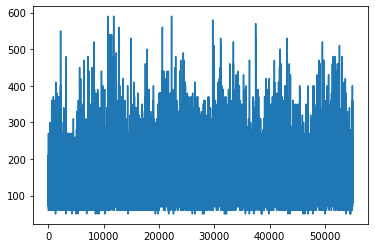

In [ ]:
print(best_score)
plt.plot(np.arange(len(score_history)),score_history)

In [ ]:
def lqr(A,B,Q,R):
    """Solve the continuous time lqr controller.

    dx/dt = A x + B u

    cost = integral x.T*Q*x + u.T*R*u
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R)*(B.T*X))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)

    return K, X, eigVals

g=env.gravity
l=env.length
m_cart=env.masscart
m_pole =env.masspole

A=np.zeros((4,4))
A[0,1]=1
A[2,3]=1
A[1,2]=-g*m_pole/m_cart
A[3,2]=-g*(m_pole+m_cart)/(m_cart*l)
print(A)

B=np.zeros((4,1))
B[1]=1/m_cart
B[3]=1/(m_cart*l)
Q=np.diagflat([2,1,10,100])
R=np.array([[0.01]])
K, S, E = lqr(A, B, Q, R)

[[  0.     1.     0.     0.  ]
 [  0.     0.    -0.98   0.  ]
 [  0.     0.     0.     1.  ]
 [  0.     0.   -21.56   0.  ]]


# Sweep

In [ ]:
env = CartPoleEnv(use_theta_threshold=True)

n_sweeps = 20

n_games = 12000

n_steps=200

noise_sigma_list = []
fc1_list = []
fc2_list = []
alpha_list = []
beta_list = []

best_score_list = []

for j in range(n_sweeps):


  noise_sigma = np.random.choice([1, 0.5, 0.1, 0.05, 0.01])
  fc1 = np.random.choice([400, 300, 200, 100, 70, 50])
  fc2 = np.random.choice([400, 300, 200, 100, 70, 50])
  alpha = np.random.choice([0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001])
  beta = np.random.choice([0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001])

  # str(alpha) +'_'+ str(beta) +'_'+ str(gamma) +'_' +str(fc1_dims) +'_'+ str(fc2_dims) +'_'+ str(noise_sigma)
  alpha = 0.0001
  beta = 0.001
  gamma = 0.99
  fc1 = 300
  fc2 = 100
  noise_sigma = 0.2

  print(n_sweeps)
  print('noise_sigma: ',noise_sigma)
  print('fc1 ',fc1)
  print('fc2 ',fc2)
  print('alpha ', alpha)
  print('beta ',beta)



  noise_sigma_list.append(noise_sigma)
  fc1_list.append(fc1)
  fc2_list.append(fc2)
  alpha_list.append(alpha)
  beta_list.append(beta)

  agent = Agent(alpha=alpha, beta=beta, 
                  input_dims=env.observation_space.shape, output_bounds=15,
                  tau=0.001,
                  fc1_dims=fc1, fc2_dims=fc2, 
                  n_actions=1,
                  noise_sigma = noise_sigma)

  # agent.load_models()


  best_score = env.reward_range[0]
  score_history = []
  score_action_history = []

  for i in range(n_games):
      observation = env.reset()
      # print(observation.shape)
      # print(observation)
      done = False
      score = 0
      agent.noise.reset()
      k=0
      while not done:
          # env.render()
          k+=1
          
          action = agent.choose_action(observation)[0]
          # print(action)
          observation_, reward, done, info = env.step_force(action)
          # print(observation_.shape) 
          # print(observation_)
          agent.remember(observation, action, reward, observation_, done)
          agent.learn()
          score += reward
          observation = observation_
          if k>n_steps:
              done=True


      score_history.append(score)
      avg_score = np.mean(score_history[-100:])


      if avg_score > best_score and i > 80:
          best_score = avg_score
          agent.save_models()

      # print('episode ', i, 'score %.1f' % score,'episode length ',k,
      #         'average score %.1f' % avg_score)
      print('episode ', i, 'score %.1f' % score,'episode length ',k,
            'average score %.1f' % avg_score, 'best score:%.1f' %best_score)
  best_score_list.append(best_score)

Streaming output truncated to the last 5000 lines.
episode  1236 score 26.7 episode length  27 average score 32.0 best score:47.7
episode  1237 score 10.2 episode length  19 average score 31.9 best score:47.7
episode  1238 score 25.6 episode length  20 average score 31.9 best score:47.7
episode  1239 score 343.7 episode length  201 average score 34.3 best score:47.7
episode  1240 score 4.9 episode length  14 average score 34.2 best score:47.7
episode  1241 score 46.4 episode length  30 average score 34.6 best score:47.7
episode  1242 score 83.9 episode length  67 average score 35.0 best score:47.7
episode  1243 score 5.8 episode length  25 average score 34.8 best score:47.7
episode  1244 score -4.5 episode length  16 average score 34.8 best score:47.7
episode  1245 score 94.6 episode length  59 average score 34.5 best score:47.7
episode  1246 score 22.5 episode length  25 average score 34.5 best score:47.7
episode  1247 score -0.3 episode length  13 average score 33.6 best score:47.7
e

In [ ]:
print(best_score_list)
print(max)

NameError: ignored

[1.00000000e-01 2.78255940e-01 7.74263683e-01 2.15443469e+00
 5.99484250e+00 1.66810054e+01 4.64158883e+01 1.29154967e+02
 3.59381366e+02 1.00000000e+03]


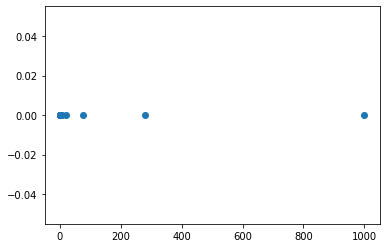

In [ ]:
# max=np.log(20)
# print()
print(np.logspace(-1, 3, 10))
log_num=np.logspace(-2, 3, 10)

plt.scatter(log_num,np.zeros_like(log_num))

In [ ]:
env = gym.make('CartPole-v1')
n_games = 1200
n_steps=400

score_history = []
score_action_history = []
prev_screen = env.render(mode='rgb_array')
# print(prev_screen)

In [ ]:
# env = CartPoleEnv(use_theta_threshold=True)
env = gym.make('CartPole-v1')
n_games = 1200

n_steps=400

score_history = []
score_action_history = []
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(n_games):
    observation = env.reset()
    
    done = False
    score = 0
    k=0
    while not done:
        screen = env.render(mode='rgb_array')
        k+=1
        
        action = np.dot(K,observation)[0,0]
        observation_, reward, done, info = env.step_force(action)
        score += reward
        observation = observation_

        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if k>n_steps:
            done=True
    
        
    
    score_history.append(score)
    score_action_history.append(score/k)
    
    avg_score = np.mean(score_history[-100:])
    avg_action_score = np.mean(score_action_history[-100:])

    
    print('episode ', i, 'score %.1f' % score_action_history[-1],'episode length ',k,
            'average score %.1f' % avg_action_score)
ipythondisplay.clear_output(wait=True)
env.close()
# env.close() 
print('mean action reward %.1f' % np.mean(score_action_history))


NameError: ignored

# Inspecting results

In [ ]:
env = CartPoleEnv(use_theta_threshold=True)
# env = gym.make('LunarLanderContinuous-v2')
agent = Agent(alpha=0.0001, beta=0.001, 
                input_dims=env.observation_space.shape, output_bounds=30,
                tau=0.001,
                batch_size=64, fc1_dims=400, fc2_dims=300, 
                n_actions=1)
agent.load_models()

... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...
... loading checkpoint ...


In [ ]:
observation = env.reset()
# print(observation.shape)
# print(observation)
done = False
score = 0
agent.noise.reset()
k=0
n_steps=400
while not done:
    k+=1
    
    action = agent.choose_action_no_noise(observation)[0]

    observation_, reward, done, info = env.step_force(action)

    agent.remember(observation, action, reward, observation_, done)
    # agent.learn()

    score += reward
    observation = observation_
    if k>n_steps:
        done=True

print(score)

405.00974916858075


In [ ]:
# fig, ax = plt.subplots(2,3,figsize=(17,15))
# data = agent.memory.sample_buffer(1000)[0]

# actions = agent.choose_action_no_noise_batch(data)
# print(actions.shape)
# # xx, yy = np.meshgrid(data[:,0],data[:,1])
# ax[0,0].contourf(data[:,0],data[:,1],actions)
# ax[0,0].contourf(data[:,0],data[:,1],actions)
# ax[0,1].contourf(data[:,0],data[:,2],actions)
# ax[0,2].contourf(data[:,0],data[:,3],actions)
# ax[1,0].contourf(data[:,1],data[:,2],actions)
# ax[1,1].contourf(data[:,1],data[:,3],actions)
# ax[1,2].contourf(data[:,2],data[:,3],actions)

In [ ]:
print(agent.memory.sample_buffer(100)[0].shape)

(100, 4)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import scipy.linalg

np.random.seed(19680801)


# fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(17,15))

# data = agent.memory.sample_buffer(100)[0]
def contour_interpol(fig, ax, a, b,const=0 npts = 1000, ngridx = 200, ngridy = 400):
  names=['x','x_dot','theta','theta_dot']
  data = np.zeros((npts,4))
  data[:,a] = np.random.uniform(-0.8, 0.8, npts)
  data[:,b] = np.random.uniform(-0.4, 0.4, npts)
  # data[:,0] = np.random.uniform(-0.8, 0.8, npts)
  # data[:,1] = np.random.uniform(-0.4, 0.4, npts)
  # data[:,2] = np.random.uniform(-0.04, 0.04, npts)
  # data[:,3] = np.random.uniform(-0.7, 0.7, npts)
  x, y = data[:,a], data[:,b]


  z = actions = agent.choose_action_no_noise_batch(data)[:,0]

  # fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(17,15))

  # -----------------------
  # Interpolation on a grid
  # -----------------------
  # A contour plot of irregularly spaced data coordinates
  # via interpolation on a grid.

  # Create grid values first.
  xi = np.linspace(-np.max(x), np.max(x), ngridx)
  yi = np.linspace(-np.max(y), np.max(y), ngridy)

  # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
  triang = tri.Triangulation(x, y)
  interpolator = tri.LinearTriInterpolator(triang, z)
  Xi, Yi = np.meshgrid(xi, yi)
  zi = interpolator(Xi, Yi)

  # Note that scipy.interpolate provides means to interpolate data on a grid
  # as well. The following would be an alternative to the four lines above:
  #from scipy.interpolate import griddata
  #zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='linear')

  ax.contour(xi, yi, zi, levels=14, linewidths=0.5, colors='k')
  cntr1 = ax.contourf(xi, yi, zi, levels=14, cmap="RdBu_r")

  clbar = fig.colorbar(cntr1, ax=ax)
  clbar.ax.set_ylabel('Force[N]')
  ax.plot(x, y, 'ko', ms=3)
  # ax1.set(xlim=(-1, 1), ylim=(-0.7, 0.5))
  ax.set_title(names[a] +' vs ' + names[b])
  

def lqr(A,B,Q,R):
    """Solve the continuous time lqr controller.

    dx/dt = A x + B u

    cost = integral x.T*Q*x + u.T*R*u
    """
    #ref Bertsekas, p.151

    #first, try to solve the ricatti equation
    X = np.matrix(scipy.linalg.solve_continuous_are(A, B, Q, R))

    #compute the LQR gain
    K = np.matrix(scipy.linalg.inv(R)*(B.T*X))

    eigVals, eigVecs = scipy.linalg.eig(A-B*K)

    return K, X, eigVals

g=env.gravity
l=env.length
m_cart=env.masscart
m_pole =env.masspole

A=np.zeros((4,4))
A[0,1]=1
A[2,3]=1
A[1,2]=-g*m_pole/m_cart
A[3,2]=-g*(m_pole+m_cart)/(m_cart*l)
print(A)

B=np.zeros((4,1))
B[1]=1/m_cart
B[3]=1/(m_cart*l)
Q=np.diagflat([2,1,10,100])
R=np.array([[0.01]])
K, S, E = lqr(A, B, Q, R)

[[  0.     1.     0.     0.  ]
 [  0.     0.    -0.98   0.  ]
 [  0.     0.     0.     1.  ]
 [  0.     0.   -21.56   0.  ]]


In [ ]:
# fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(17,15))

z_test=np.zeros((4,4))
z_test= z_test+4
print(z_test)

[[4. 4. 4. 4.]
 [4. 4. 4. 4.]
 [4. 4. 4. 4.]
 [4. 4. 4. 4.]]


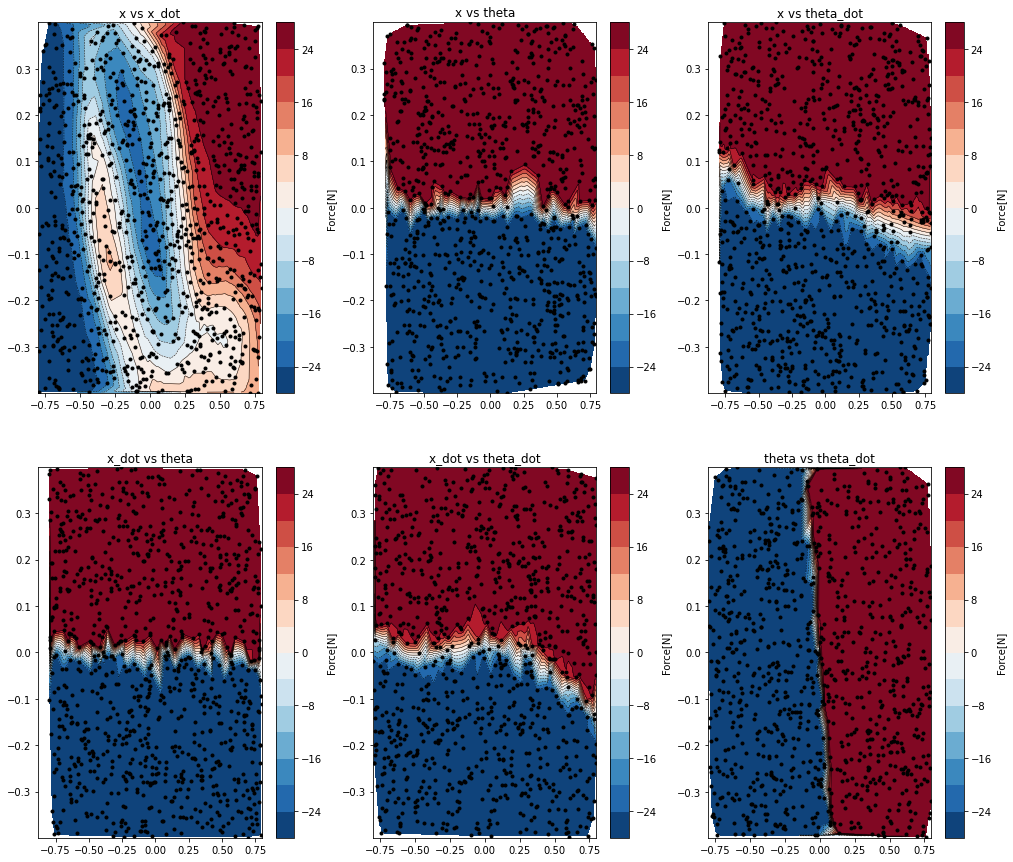

In [ ]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(17,15))
contour_interpol(fig, ax1, 0,1)
contour_interpol(fig, ax2, 0,2)
contour_interpol(fig, ax3, 0,3)
contour_interpol(fig, ax4, 1,2)
contour_interpol(fig, ax5, 1,3)
contour_interpol(fig, ax6, 2,3)

# LQR results 

(20, 20)
(20,)


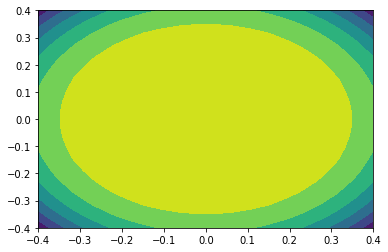

In [ ]:
x = np.linspace(-0.4,0.4,20)
y = np.linspace(-0.4,0.4,20)
xx, yy = np.meshgrid(x, y)
print(xx.shape)
z = np.sin(xx**2 + yy**2) / (xx**2 + yy**2)
# print(z)
print(x.shape)
h = plt.contourf(x,y,z)

In [ ]:
print(agent.memory.action_memory[:,0].shape)
print(agent.memory.state_memory[:,0].shape)
test=np.array([[0.3,0.2,-0.1,0.1] ,[-0,2,0.2,-0.1,0.1]])

agent.choose_action_no_noise(test)

(1000000,)
(1000000,)


ValueError: ignored

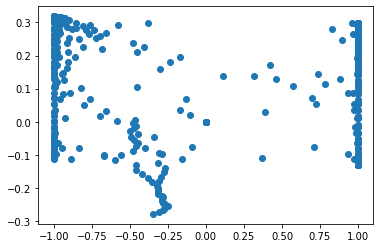

In [ ]:
plt.scatter(agent.memory.action_memory[:,0],agent.memory.state_memory[:,1])

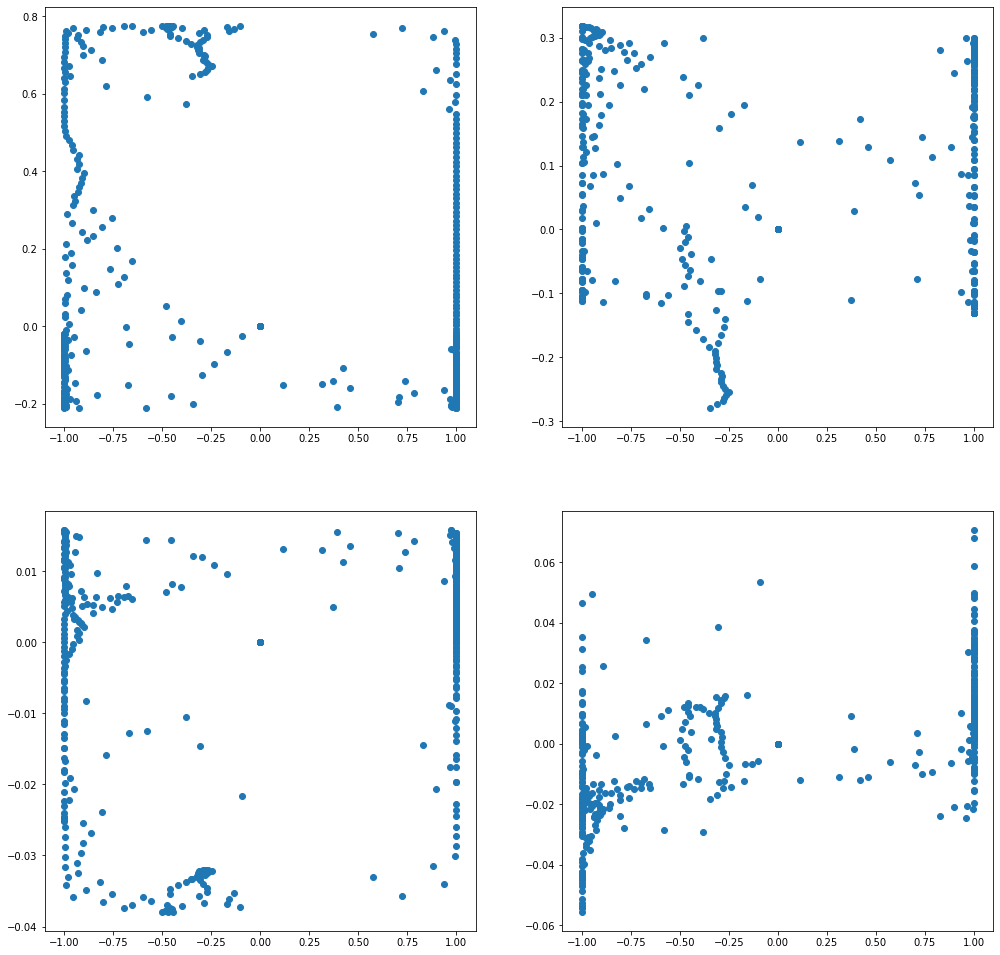

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(17,17))
ax[0,0].scatter(agent.memory.action_memory[:,0],agent.memory.state_memory[:,0])
ax[0,1].scatter(agent.memory.action_memory[:,0],agent.memory.state_memory[:,1])
ax[1,0].scatter(agent.memory.action_memory[:,0],agent.memory.state_memory[:,2])
ax[1,1].scatter(agent.memory.action_memory[:,0],agent.memory.state_memory[:,3])